# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [2]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.0.0


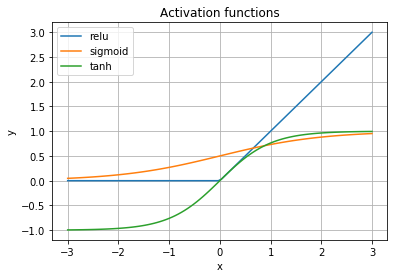

In [3]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [4]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.0.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [46]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
#     pass

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    import os
    cifar10_dir = "data/cifar-10-batches-py"
    all_batches = []
    all_labels = []
    for b in range(1,6):
        f_train_curr = os.path.join(cifar10_dir, 'data_batch_%d' %b)
        d_data, d_labels = unpickle(f_train_curr)
        batch = d_data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
#         print(batch.shape)
        labels = np.array(d_labels)
        all_batches.append(batch)
        all_labels.append(labels)
        
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
#     print(data_train.shape, labels_train.shape)
    x_train = data_train[:num_training]
    x_val = data_train[num_training:]
    y_train = labels_train[:num_training]
    y_val = labels_train[num_training:]
    del batch, labels
    return x_train, y_train, x_val, y_val
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
#     pass

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    import os
    cifar10_dir = "data/cifar-10-batches-py"
    f_test = os.path.join(cifar10_dir, 'test_batch')
    d_data, d_labels = unpickle(f_test)
    data_test = d_data.reshape(10000,3,32,32).transpose(0,2,3,1).astype('float')
    labels_test = np.array(d_labels)
    return data_test, labels_test
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [77]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


    
#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def avg_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.avg_pool(input, ksize=ksize, strides=strides, padding='SAME')
    
def drop(input, keep_prob, training):
    return tf.layers.dropout(input, 1-keep_prob, training=training)
    
def fc(input,units):
    return tf.contrib.layers.fully_connected(input, units,activation_fn=None)
    
def bn(input, training, reuse=None):
    return tf.layers.batch_normalization(inputs=input, training=training, reuse=reuse)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

In [48]:
# tf.reset_default_graph()
# sess = tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
# X = tf.convert_to_tensor(X_val,dtype=tf.float32)
# conv1 = conv2d(X, 7, 1, 32)
# relu1 = tf.nn.relu(conv1)
# pool1 = max_pool(relu1, 3, 2)            
# print('conv1 layer: ' + str(pool1.get_shape()))

In [49]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.pool2, [-1, 8*8*64])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fc(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            self.dropout = tf.layers.dropout(self.relu3, 1-self.keep_prob, training=self.is_train)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.dropout.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fc(self.dropout, 10)          
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
#         global_step = tf.Variable(0, trainable=False)
        global_step = tf.contrib.framework.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(5e-4,global_step,500,0.96,staircase=True)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=learning_rate).minimize(self.loss_op, global_step=global_step) 
#         print(global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {self.X : X_, self.Y : Y_, self.keep_prob:0.5, self.is_train:True}              
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(1,2,1)
            plt.plot(losses,'r')
            plt.title("Losses")
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(1,2,2)
            plt.plot(accuracies,'g')
            plt.title("Accuracies")
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {self.X: X_, self.Y : Y_, self.keep_prob:0.5, self.is_train: False}
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 42.221, accuracy = 0.062
iteration (50): loss = 2.056, accuracy = 0.242
iteration (100): loss = 1.779, accuracy = 0.422
iteration (150): loss = 1.806, accuracy = 0.344
iteration (200): loss = 1.762, accuracy = 0.398
iteration (250): loss = 1.770, accuracy = 0.344
iteration (300): loss = 1.509, accuracy = 0.492
iteration (350): loss = 1.639, accuracy = 0.383


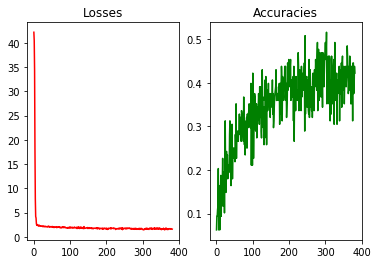

validation for epoch 0
-  epoch 0: validation accuracy = 0.477
train for epoch 1
iteration (400): loss = 1.436, accuracy = 0.477
iteration (450): loss = 1.512, accuracy = 0.492
iteration (500): loss = 1.683, accuracy = 0.383
iteration (550): loss = 1.379, accuracy = 0.508
iteration (600): loss = 1.473, accuracy = 0.469
iteration (650): loss = 1.509, accuracy = 0.461
iteration (700): loss = 1.490, accuracy = 0.477
iteration (750): loss = 1.267, accuracy = 0.594


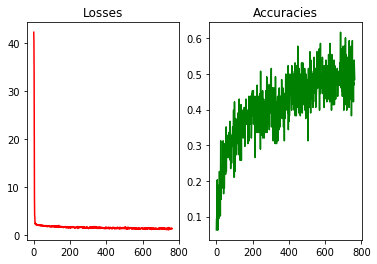

validation for epoch 1
-  epoch 1: validation accuracy = 0.538
train for epoch 2
iteration (800): loss = 1.417, accuracy = 0.508
iteration (850): loss = 1.456, accuracy = 0.469


KeyboardInterrupt: 

In [50]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [81]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 10

    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        
        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 3, 1, 96)
            self.bn1 = bn(self.conv1, self.is_train)
            self.relu1 = tf.nn.relu(self.bn1)
            self.pool1 = max_pool(self.relu1, 2, 2)
            print('conv1 layer: '+ str(self.pool1.get_shape()))
            
            
        with tf.variable_scope('conv2'):
            self.conv2 = conv2d(self.pool1, 3, 1, 256)
            self.bn2 = bn(self.conv2, self.is_train)
            self.relu2 = tf.nn.relu(self.bn2)
            self.pool2 = max_pool(self.relu2, 2, 2)
            print('conv2 layer: '+ str(self.pool2.get_shape()))
            
            
        with tf.variable_scope('conv3'):
            self.conv3 = conv2d(self.pool2, 3, 1, 384)
            self.relu3 = tf.nn.relu(self.conv3)
            self.drop3 = drop(self.relu3, self.keep_prob, self.is_train)
            print('conv3 layer: '+ str(self.relu3.get_shape()))
            
            
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.drop3, 3, 1, 384)
            self.relu4 = tf.nn.relu(self.conv4)
            self.pool4 = max_pool(self.relu4, 2, 2)
            print('conv4 layer: '+ str(self.pool4.get_shape()))
            
            
        with tf.variable_scope('conv5'):
            self.conv5 = conv2d(self.pool4, 3, 1, 256)
            self.relu5 = tf.nn.relu(self.conv5)
            self.pool5 = avg_pool(self.relu5, 2, 2)
            print('conv5 layer: '+ str(self.pool5.get_shape()))
            
            
        self.flat = tf.reshape(self.pool5, [-1,2*2*256])
        
        
        with tf.variable_scope('fc6'):
            self.fc6 = fc(self.flat, 128)
            self.drop6 = drop(self.fc6, self.keep_prob, self.is_train)
            print('fc6 layer: '+ str(self.drop6.get_shape()))
            
            
        with tf.variable_scope('fc7'):
            self.fc7 = fc(self.drop6, 10)
            print('fc7 layer: '+ str(self.fc7.get_shape()))
        return self.fc7


    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
#         self.reuse = tf.placeholder(tf.bool)
      
    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        global_step = tf.contrib.framework.get_or_create_global_step()
        learning_rate = tf.train.exponential_decay(5e-4,global_step,500,0.96,staircase=True)
#         if self.use_batch_norm:
#             # If we don't include the update ops as dependencies on the train step, the 
#             # tf.layers.batch_normalization layers won't update their population statistics,
#             # which will cause the model to fail at inference time
#             with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#                 train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
#         else:
#             train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            self.train_op = tf.train.AdamOptimizer(
                learning_rate=learning_rate).minimize(self.loss_op, global_step=global_step) 
#         print(global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
        
    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
#         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#         with tf.control_dependencies(update_ops):
#             train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]
                
                feed_dict = {self.X : X_, self.Y : Y_, self.keep_prob:0.5, self.is_train:True}              
                
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(1,2,1)
            plt.plot(losses,'r')
            plt.title("Losses")
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(1,2,2)
            plt.plot(accuracies,'g')
            plt.title("Accuracies")
            plt.show()
            

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            feed_dict = {self.X: X_, self.Y : Y_, self.keep_prob:0.5, self.is_train: False}
            
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Your model  -----
conv1 layer: (?, 16, 16, 96)
conv2 layer: (?, 8, 8, 256)
conv3 layer: (?, 8, 8, 384)
conv4 layer: (?, 4, 4, 384)
conv5 layer: (?, 2, 2, 256)
fc6 layer: (?, 128)
fc7 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 3.655, accuracy = 0.086
iteration (50): loss = 1.832, accuracy = 0.320
iteration (100): loss = 1.650, accuracy = 0.352
iteration (150): loss = 1.620, accuracy = 0.383
iteration (200): loss = 1.442, accuracy = 0.430
iteration (250): loss = 1.540, accuracy = 0.484
iteration (300): loss = 1.416, accuracy = 0.469
iteration (350): loss = 1.445, accuracy = 0.477


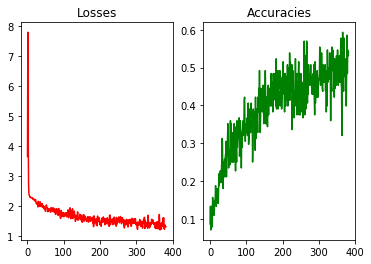

validation for epoch 0
-  epoch 0: validation accuracy = 0.461
train for epoch 1
iteration (400): loss = 1.320, accuracy = 0.539
iteration (450): loss = 1.300, accuracy = 0.508
iteration (500): loss = 1.291, accuracy = 0.500
iteration (550): loss = 1.112, accuracy = 0.625
iteration (600): loss = 1.130, accuracy = 0.609
iteration (650): loss = 1.258, accuracy = 0.523
iteration (700): loss = 1.265, accuracy = 0.547
iteration (750): loss = 0.957, accuracy = 0.648


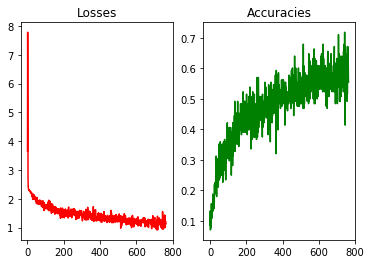

validation for epoch 1
-  epoch 1: validation accuracy = 0.576
train for epoch 2
iteration (800): loss = 1.052, accuracy = 0.602
iteration (850): loss = 1.193, accuracy = 0.586
iteration (900): loss = 1.014, accuracy = 0.695
iteration (950): loss = 0.967, accuracy = 0.680
iteration (1000): loss = 0.937, accuracy = 0.633
iteration (1050): loss = 0.865, accuracy = 0.680
iteration (1100): loss = 0.857, accuracy = 0.664


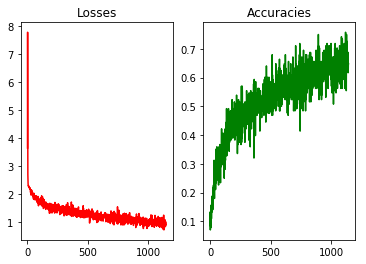

validation for epoch 2
-  epoch 2: validation accuracy = 0.482
train for epoch 3
iteration (1150): loss = 0.907, accuracy = 0.703
iteration (1200): loss = 0.833, accuracy = 0.688
iteration (1250): loss = 1.047, accuracy = 0.633
iteration (1300): loss = 0.994, accuracy = 0.617
iteration (1350): loss = 0.734, accuracy = 0.727
iteration (1400): loss = 0.995, accuracy = 0.695
iteration (1450): loss = 0.915, accuracy = 0.648
iteration (1500): loss = 0.619, accuracy = 0.781


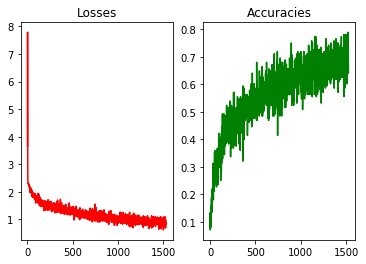

validation for epoch 3
-  epoch 3: validation accuracy = 0.650
train for epoch 4
iteration (1550): loss = 0.725, accuracy = 0.727
iteration (1600): loss = 0.841, accuracy = 0.727
iteration (1650): loss = 0.842, accuracy = 0.711
iteration (1700): loss = 0.878, accuracy = 0.719
iteration (1750): loss = 0.882, accuracy = 0.695
iteration (1800): loss = 0.757, accuracy = 0.688
iteration (1850): loss = 0.886, accuracy = 0.703
iteration (1900): loss = 0.786, accuracy = 0.750


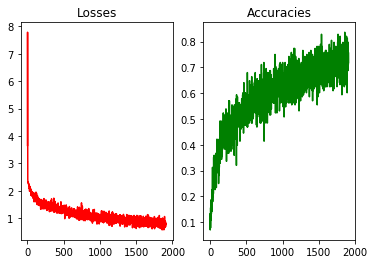

validation for epoch 4
-  epoch 4: validation accuracy = 0.605
train for epoch 5
iteration (1950): loss = 0.981, accuracy = 0.602
iteration (2000): loss = 0.719, accuracy = 0.727
iteration (2050): loss = 0.741, accuracy = 0.727
iteration (2100): loss = 0.978, accuracy = 0.703
iteration (2150): loss = 0.968, accuracy = 0.672
iteration (2200): loss = 0.779, accuracy = 0.727
iteration (2250): loss = 0.790, accuracy = 0.719


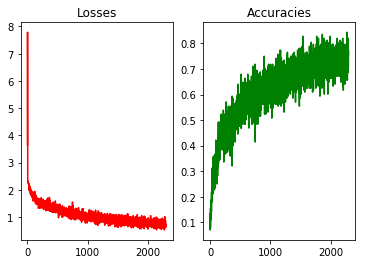

validation for epoch 5
-  epoch 5: validation accuracy = 0.569
train for epoch 6
iteration (2300): loss = 0.770, accuracy = 0.719
iteration (2350): loss = 0.739, accuracy = 0.742
iteration (2400): loss = 0.721, accuracy = 0.781
iteration (2450): loss = 0.743, accuracy = 0.742
iteration (2500): loss = 0.721, accuracy = 0.773
iteration (2550): loss = 0.719, accuracy = 0.719
iteration (2600): loss = 0.524, accuracy = 0.828
iteration (2650): loss = 0.726, accuracy = 0.766


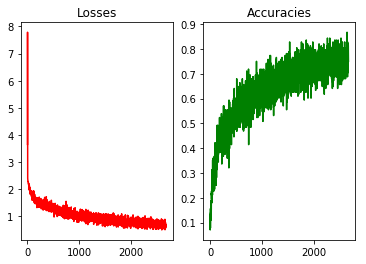

validation for epoch 6
-  epoch 6: validation accuracy = 0.640
train for epoch 7
iteration (2700): loss = 0.831, accuracy = 0.711
iteration (2750): loss = 0.758, accuracy = 0.703
iteration (2800): loss = 0.642, accuracy = 0.789
iteration (2850): loss = 0.596, accuracy = 0.789
iteration (2900): loss = 0.499, accuracy = 0.820
iteration (2950): loss = 0.719, accuracy = 0.758
iteration (3000): loss = 0.696, accuracy = 0.758
iteration (3050): loss = 0.654, accuracy = 0.805


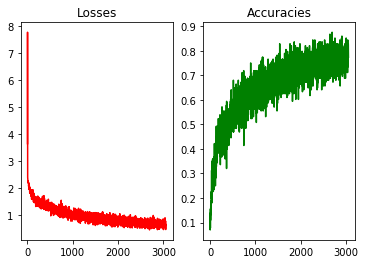

validation for epoch 7
-  epoch 7: validation accuracy = 0.683
train for epoch 8
iteration (3100): loss = 0.651, accuracy = 0.734
iteration (3150): loss = 0.729, accuracy = 0.719
iteration (3200): loss = 0.613, accuracy = 0.750
iteration (3250): loss = 0.644, accuracy = 0.766
iteration (3300): loss = 0.554, accuracy = 0.828
iteration (3350): loss = 0.760, accuracy = 0.711
iteration (3400): loss = 0.573, accuracy = 0.805


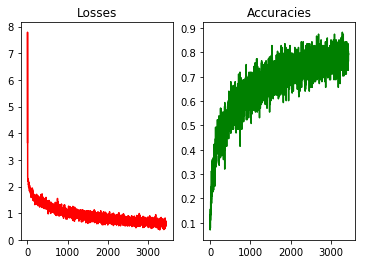

validation for epoch 8
-  epoch 8: validation accuracy = 0.560
train for epoch 9
iteration (3450): loss = 0.651, accuracy = 0.742
iteration (3500): loss = 0.652, accuracy = 0.789
iteration (3550): loss = 0.783, accuracy = 0.695
iteration (3600): loss = 0.604, accuracy = 0.797
iteration (3650): loss = 0.633, accuracy = 0.812
iteration (3700): loss = 0.612, accuracy = 0.789
iteration (3750): loss = 0.616, accuracy = 0.805
iteration (3800): loss = 0.513, accuracy = 0.844


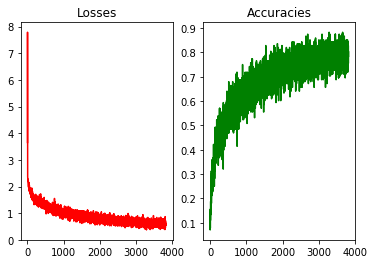

validation for epoch 9
-  epoch 9: validation accuracy = 0.679
***** test accuracy: 0.660
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [82]:
# # Clear old computation graphs
# tf.reset_default_graph()

# # Train our sample model
# with tf.Session() as sess:
#     model = YourModel()
#     model.train(sess, X_train, Y_train, X_val, Y_val)
#     accuracy = model.evaluate(sess, X_test, Y_test)
#     print('***** test accuracy: %.3f' % accuracy)
#     saver = tf.train.Saver()
#     model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
#     print("Model saved in %s" % model_path)

In [83]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = X_train.reshape(-1, 32*32*3)
scaler = StandardScaler().fit(X_train_)
X_train_ = scaler.transform(X_train_)
X_train_ = X_train.reshape(-1,32,32,3)
X_val_ = scaler.transform(X_val.reshape(-1,32*32*3))
X_val_ = X_val_.reshape(-1,32,32,3)
X_test_ = scaler.transform(X_test.reshape(-1,32*32*3))
X_test_ = X_test_.reshape(-1, 32,32,3)

# X_train_ = X_train
# X_val_= X_val
# X_test_ = X_test
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [ ]:
import pickle

In [ ]:
with open("data/processed/X_train_.pkl") as f:
    pickle.dump(X_train_, f)
with open('data/processed/Y_train.pkl') as f:
    pickle.dump(Y_train, f)
with open('data/processed/X_val_.pkl') as f:
    pickle.dump(X_val_, f)
with open('data/processed/Y_val.pkl') as f:
    pickle.dump(Y_val, f)
with open('data/processed/X_test_.pkl') as f:
    pickle.dump(X_test_, f)
with open('data/processed/Y_test.pkl') as f:
    pickle.dump(Y_test, f)

In [ ]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")